# Convert chunk probabilities into doc probabilities

In [7]:
import pandas as pd
import numpy as np
import os
import yaml
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score, accuracy_score
import seaborn as sns

In [10]:
# Configurable paths
PROJ_DIR = '/zfs/projects/faculty/jinhwan-green-patents'

# Load Configuration
with open(f'{PROJ_DIR}/config.yaml', 'r') as file:
    config = yaml.safe_load(file)

# Extract configuration parameters
SECTION = config['section']  # e.g., 'F'
YEAR_THRESHOLD = config['year']  # e.g., 2010

# Input directory for claims files
input_dir = f"{PROJ_DIR}/predictions/claims-model"

In [21]:
# Function to clean, convert, ensure two elements, and take the second one (prob of green)
def clean_convert(lst):
    # Join into a single string and replace sequences of spaces with a comma
    joined_str = ','.join(lst).replace(' ', ',')
    # Remove non-numeric characters at the start and end
    cleaned_str = joined_str.strip('[]')
    # Split by comma, filter out empty strings, and convert to float
    float_elements = [float(e) for e in cleaned_str.split(',') if e]
    # Ensure the list has exactly two elements
    if len(float_elements) != 2:
        return [None, None]  # or any other way you want to handle irregular cases
    return float_elements[1]

In [34]:
def plot_confusion(y_true, y_pred):
    # Generate the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Plotting confusion matrix
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Extracting matrix components
    tn, fp, fn, tp = cm.ravel()

    # Calculating metrics
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    fpr = fp / (fp + tn)
    fnr = fn / (fn + tp)
    
    # Calculate precision, recall, and F1 score
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    f1_score_hand = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1_score_hand:.4f}")

    print(f"Accuracy: {accuracy*100:.4f}%")
    print(f"False Positive Rate: {fpr*100:.4f}%")
    print(f"False Negative Rate: {fnr*100:.4f}%")
    
    
    # Calculate and print F1 scores per class
    f1_scores = f1_score(y_true, y_pred, average=None)
    print(f"F1 Scores per class: {f1_scores}")

    # Calculate other averages as needed
    f1_macro = f1_score(y_true, y_pred, average='macro')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    f1_micro = f1_score(y_true, y_pred, average='micro')

    print(f"Macro-average F1: {f1_macro}")
    print(f"Weighted-average F1: {f1_weighted}")
    print(f"Micro-average F1: {f1_micro}")

In [11]:
# Paths to the pre-year and post-year predictions and probability claims files
pre_year_claims_file = os.path.join(input_dir, f'pre_{YEAR_THRESHOLD}_claims_predictions.csv')
post_year_claims_file = os.path.join(input_dir, f'post_{YEAR_THRESHOLD}_claims_predictions.csv')

In [16]:
df_pre = pd.read_csv(pre_year_claims_file)
df_post = pd.read_csv(post_year_claims_file)

In [13]:
df_pre.shape

(880697, 6)

In [17]:
df_post.shape

(1284345, 6)

In [14]:
df_pre.head()

,pgpub_id,chunk_id,label,year,predictions,probabilities
0,20010000574,0,0,2001.0,0,0.000072
1,20010000574,1,0,2001.0,0,0.000032
2,20010000574,2,0,2001.0,0,0.000072
3,20010000574,3,0,2001.0,0,0.000014
4,20010000574,4,0,2001.0,0,0.000013


In [20]:
df_post.head()

,pgpub_id,chunk_id,label,year,predictions,probabilities
0,20110094190,0,0,2011.0,0,0.000015
1,20110094190,1,0,2011.0,0,0.000015
2,20110094190,2,0,2011.0,0,0.000019
3,20110094190,3,0,2011.0,0,0.000072
4,20110094190,4,0,2011.0,0,0.000019


In [15]:
len(set(df_pre['pgpub_id']))

184158

In [18]:
len(set(df_post['pgpub_id']))

267632

In [22]:
# combine the df's
df = pd.concat([df_pre, df_post], axis=0, ignore_index=True)

In [23]:
df.shape

(2165042, 6)

In [24]:
len(set(df['pgpub_id']))

451790

In [49]:
grouped = df.groupby('pgpub_id').agg({
                        'probabilities': 'mean',
                        'label': 'mean',
                        'year': 'mean'
                    }).reset_index()

In [50]:
grouped.shape

(451790, 4)

In [51]:
# probability and label per doc
grouped.head()

,pgpub_id,probabilities,label,year
0,20010000574,0.003712,0.0,2001.0
1,20010000846,0.000013,0.0,2001.0
2,20010000847,0.000014,0.0,2001.0
3,20010000850,0.000013,0.0,2001.0
4,20010000868,0.003712,0.0,2001.0


In [52]:
grouped['label'].value_counts()

label
0.0    416414
1.0     35376
Name: count, dtype: int64

In [53]:
# Determine preds_docs based on 'prob_green' mean
preds_docs = (grouped['probabilities'] > 0.5).astype(int).tolist()

In [54]:
grouped['pred_claims'] = preds_docs

In [55]:
grouped.head()

,pgpub_id,probabilities,label,year,pred_claims
0,20010000574,0.003712,0.0,2001.0,0
1,20010000846,0.000013,0.0,2001.0,0
2,20010000847,0.000014,0.0,2001.0,0
3,20010000850,0.000013,0.0,2001.0,0
4,20010000868,0.003712,0.0,2001.0,0


In [56]:
grouped['pred_claims'].value_counts()

pred_claims
0    424471
1     27319
Name: count, dtype: int64

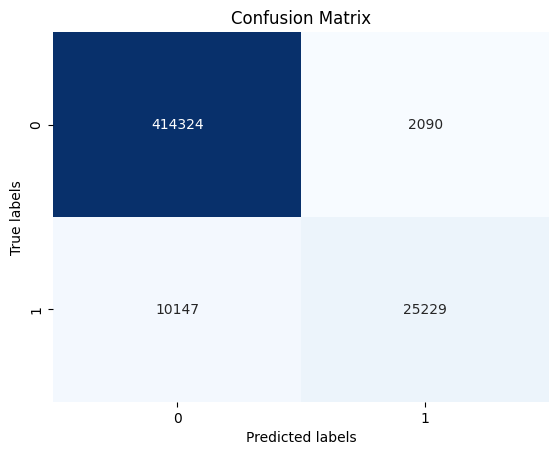

Precision: 0.9235
Recall: 0.7132
F1 Score: 0.8048
Accuracy: 97.2914%
False Positive Rate: 0.5019%
False Negative Rate: 28.6833%
F1 Scores per class: [0.98544747 0.80481697]
Macro-average F1: 0.8951322230160194
Weighted-average F1: 0.9713037694834157
Micro-average F1: 0.9729144071360588


In [57]:
plot_confusion(grouped['label'], grouped['pred_claims'])

In [58]:
grouped.to_csv(f'{PROJ_DIR}/predictions/claims-model/claims_model_doc_preds.csv', index=False)

In [59]:
grouped.head()

,pgpub_id,probabilities,label,year,pred_claims
0,20010000574,0.003712,0.0,2001.0,0
1,20010000846,0.000013,0.0,2001.0,0
2,20010000847,0.000014,0.0,2001.0,0
3,20010000850,0.000013,0.0,2001.0,0
4,20010000868,0.003712,0.0,2001.0,0


In [61]:
# Group by year and compute metrics
metrics_per_year = grouped.groupby('year').apply(lambda x: pd.Series({
    'accuracy': accuracy_score(x['label'], x['pred_claims']),
    'precision': precision_score(x['label'], x['pred_claims'], zero_division=0),
    'recall': recall_score(x['label'], x['pred_claims'], zero_division=0),
    'f1_score': f1_score(x['label'], x['pred_claims'], zero_division=0),
    'fnr': (confusion_matrix(x['label'], x['pred_claims']).ravel()[2] / (confusion_matrix(x['label'], 
                                             x['pred_claims']).ravel()[2] + confusion_matrix(x['label'], 
                                             x['pred_claims']).ravel()[3])) if (confusion_matrix(x['label'], 
                                             x['pred_claims']).ravel()[2] + confusion_matrix(x['label'], x['pred_claims']).ravel()[3]) > 0 else 0,
    'fpr': (confusion_matrix(x['label'], x['pred_claims']).ravel()[1] / (confusion_matrix(x['label'], 
                                             x['pred_claims']).ravel()[1] + confusion_matrix(x['label'], 
                                             x['pred_claims']).ravel()[0])) if (confusion_matrix(x['label'], 
                                             x['pred_claims']).ravel()[1] + confusion_matrix(x['label'], x['pred_claims']).ravel()[0]) > 0 else 0
})).reset_index()

/tmp/ipykernel_3220301/854932953.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  metrics_per_year = grouped.groupby('year').apply(lambda x: pd.Series({


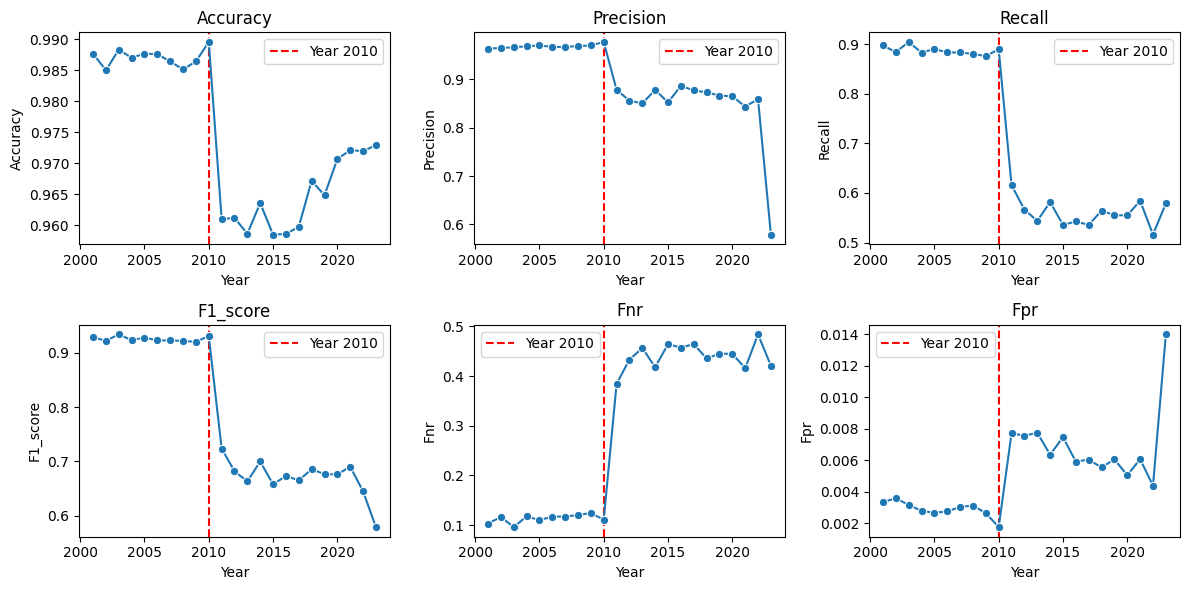

In [62]:
# Plotting the metrics per year
plt.figure(figsize=(12, 6))

# Create a subplot for each metric
metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'fnr', 'fpr']

for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 3, i)
    plt.axvline(x=2010, color='red', linestyle='--', label='Year 2010')
    sns.lineplot(x='year', y=metric, data=metrics_per_year, marker='o')
    plt.title(metric.capitalize())
    plt.xlabel('Year')
    plt.ylabel(metric.capitalize())

plt.tight_layout()
plt.show()